# Requirements

In [1]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import torch_geometric.utils.convert
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import category_encoders as ce
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 

# Data pre-processing

In [3]:
filename = "NF-UNSW-NB15.csv"
dataPS = pd.read_csv(filename)


In [4]:
print("number of begnin connections: " + str(dataPS[dataPS['Label'] == 0].shape[0]))
print("number of malicious connections: " + str(dataPS[dataPS['Label'] == 1].shape[0]))

number of begnin connections: 1550712
number of malicious connections: 72406


In [5]:
data0 = dataPS[dataPS['Label'] == 0].sample(frac=1)
data1 = dataPS[dataPS['Label'] == 1].sample(frac=1)

In [6]:
data0_split = np.array_split(data0, 20)
data1_split = np.array_split(data1, 1)

# Statistical Comparisons of Classifiers with PAIRED T-TEST

test 1:  0.4
Precision: 1.0000
Recall: 0.9739
Accuracy: 0.9871
F1 Score: 0.9868

test 2: 0.4
Precision: 1.0000
Recall: 0.9729
Accuracy: 0.9865
F1 Score: 0.9863

test 3: 0.6
Precision: 1.0000
Recall: 0.9739
Accuracy: 0.9871
F1 Score: 0.9868

test 4: 0.4
Precision: 1.0000
Recall: 0.9736
Accuracy: 0.9869
F1 Score: 0.9866

test 5: 0.2
Precision: 1.0000
Recall: 0.9731
Accuracy: 0.9867
F1 Score: 0.9864

test 6: 0.2
Precision: 1.0000
Recall: 0.9723
Accuracy: 0.9862
F1 Score: 0.9859

test 7 0.1
Precision: 1.0000
Recall: 0.9740
Accuracy: 0.9871
F1 Score: 0.9868


In [7]:
test=6
nodes_percentages=0.2
dataPSA = pd.concat([data0_split[test], data1], ignore_index=True)

In [9]:

dataPSA['IPV4_SRC_ADDR'] = dataPSA.IPV4_SRC_ADDR.apply(str)
dataPSA['L4_SRC_PORT'] = dataPSA.L4_SRC_PORT.apply(str)
dataPSA['IPV4_DST_ADDR'] = dataPSA.IPV4_DST_ADDR.apply(str)
dataPSA['L4_DST_PORT'] = dataPSA.L4_DST_PORT.apply(str)

#dataPSA["id"]=dataPSA.index.tolist()
#dataPSA["id"]=dataPSA.id.apply(str)

dataPSA['IPV4_SRC'] = dataPSA['IPV4_SRC_ADDR'].apply(lambda x: int(x.split('.')[0]))##############
dataPSA['IPV4_DST'] = dataPSA['IPV4_DST_ADDR'].apply(lambda x: int(x.split('.')[0]))##############

dataPSA['IPV4_SRC_ADDR'] = dataPSA['IPV4_SRC_ADDR'] + ':' + dataPSA['L4_SRC_PORT'] # + ':' + dataPSA["id"]
dataPSA['IPV4_DST_ADDR'] = dataPSA['IPV4_DST_ADDR'] + ':' + dataPSA['L4_DST_PORT'] # + ':' + dataPSA["id"]
#dataPSA.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

dataPSA.rename(columns={"Label": "label"},inplace = True)
label=dataPSA.label

dataPSA.drop(columns=['Attack','label'],inplace = True)
#dataPSA.drop(columns=['id'],inplace = True)


cols_to_norm =  list(set(list(dataPSA.iloc[:,:].columns ))  - set(list(['label','IPV4_DST_ADDR','IPV4_SRC_ADDR',])) )
#cols_to_norm= list([ 'L4_SRC_PORT', 'L4_DST_PORT','PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS','TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS' ])
scaler = StandardScaler()
dataPSA[cols_to_norm] = scaler.fit_transform(dataPSA[cols_to_norm])


data=  dataPSA
data['x'] = data[ cols_to_norm ].values.tolist()
data['y']= label
#data = data.sample(frac=1)

In [10]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC,IPV4_DST,x,y
0,59.166.0.5:43125,0.597813,149.171.126.7:80,-0.502002,-0.312036,-0.286307,-0.043593,-0.095043,-0.100413,-0.115685,0.856107,-0.085206,-0.993028,0.017971,"[-0.09504259216832099, -0.10041290906549338, -...",0
1,59.166.0.6:20055,-0.509792,149.171.126.5:80,-0.502002,-0.312036,-0.286307,-0.046133,-0.137384,-0.130790,-0.163398,0.856107,-0.088055,-0.993028,0.017971,"[-0.13738394667426534, -0.1307898078064195, -0...",0
2,59.166.0.3:14710,-0.766409,149.171.126.1:53,-0.503620,-0.012717,-0.557979,-0.049697,-0.140311,-0.161167,-0.211111,-1.459059,-0.088055,-0.993028,0.017971,"[-0.1403112278184049, -0.1611667065473456, -0....",0
3,175.45.176.2:35436,0.228659,149.171.126.12:445,-0.480131,-0.312036,-0.163667,-0.046339,-0.137846,-0.110539,-0.175327,0.170132,-0.086365,1.006463,0.017971,"[-0.13784614896018213, -0.11053854197913542, -...",0
4,59.166.0.3:51853,1.016850,149.171.126.1:21,-0.505537,-0.312036,-0.519168,-0.038632,-0.124161,0.091974,0.099023,0.856107,-0.088055,-0.993028,0.017971,"[-0.12416133618107768, 0.09197411629370529, -0...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149937,175.45.176.1:4400,-1.261398,149.171.126.19:21,-0.505537,-0.312036,-0.519168,-0.047728,-0.138082,-0.100413,-0.151470,0.170132,-0.085201,1.006463,0.017971,"[-0.1380817814981005, -0.10041290906549338, -0...",1
149938,175.45.176.0:47488,0.807284,149.171.126.13:80,-0.502002,-0.312036,-0.286307,-0.046387,-0.118642,-0.120664,-0.163398,0.856107,-0.087024,1.006463,0.017971,"[-0.11864209711983621, -0.12066417489277745, -...",1
149939,175.45.176.2:60822,1.447457,149.171.126.18:80,-0.502002,-0.312036,-0.286307,-0.047308,-0.121696,-0.120664,-0.151470,0.856107,-0.084347,1.006463,0.017971,"[-0.1216962573228549, -0.12066417489277745, -0...",1
149940,175.45.176.3:0,-1.472645,149.171.126.17:0,-0.506795,2.327409,-0.557979,-0.048371,-0.141118,-0.130790,-0.223040,-1.459059,-0.084078,1.006463,0.017971,"[-0.1411178161212793, -0.1307898078064195, -0....",1


In [11]:
X_train=data
y_train=label

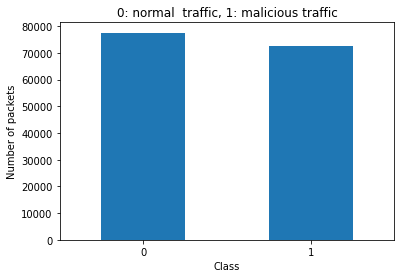

In [13]:
count_classes = pd.value_counts(X_train['y'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(X_train['y'].unique())), X_train.y.unique())
plt.title("0: normal  traffic, 1: malicious traffic")
plt.xlabel("Class")
plt.ylabel("Number of packets");

# Graph Construction

In [14]:
class CreateGraphStructures:
    def __init__(self, dataframe,subnet,inject_anomaly=False):
        self.data = dataframe  
        self.n_subnet = min(subnet,(len(dataframe)-1))     
        self.MG=nx.MultiGraph()    
        self.add_nodes()
        self.add_edges()
        if inject_anomaly:
            self.add_anomaly()
        self.MG=self.MG.to_directed()
        self.pyg_graph = torch_geometric.utils.convert.from_networkx(self.MG)
        self.g= torch_geometric.utils.to_networkx(self.pyg_graph)
        
    def get_pyg_graphh(self,):
        return self.pyg_graph        
        
    def get_NetworkX(self):
        return self.MG      
    
    def get_g(self):
        return self.g
    
    def add_anomaly(self):
        source_list = self.data['IPV4_SRC_ADDR'].to_list()
        destination_list = self.data['IPV4_DST_ADDR'].to_list()
        nodes_features = self.data['x'].to_list()
        labels = self.data['y'].to_list()
        index_list = self.data.index.to_list()
        
        for s1,d1, xr, yr, index1  in zip(source_list,destination_list,nodes_features,labels,index_list):
            comm= str(s1)+str('-')+str(d1)+str('-')+str(index1)
            self.MG.add_node(comm, x=xr*15, y = 1)
            break
    
    def add_nodes(self):
        i=0
        source_list = self.data['IPV4_SRC_ADDR'].to_list()
        destination_list = self.data['IPV4_DST_ADDR'].to_list()
        nodes_features = self.data['x'].to_list()
        labels = self.data['y'].to_list()
        index_list = self.data.index.to_list()
        
        for s1,d1, xr, yr, index1  in zip(source_list,destination_list,nodes_features,labels,index_list):
            i+=1
            b=str(i)+"/"+str(len(self.data))
            comm= str(s1)+str('-')+str(d1)+str('-')+str(index1)
            self.MG.add_node(comm, x=xr, y = yr) 
            
   
    def add_edges(self):
        i=0
        source_list = self.data['IPV4_SRC_ADDR'].to_list()
        destination_list = self.data['IPV4_DST_ADDR'].to_list()
        nodes_features = self.data['x'].to_list()
        labels = self.data['y'].to_list(),self.data.index.to_list()
        index_list = self.data.index.to_list()

        for s1,d1, index1 in zip(source_list, destination_list, index_list):      
            i+=1
            b=str(i)+"/"+str(len(self.data))
            print(b, end="\r")
            comm= str(s1)+str('-')+str(d1)+str('-')+str(index1)
            subdata=self.data.iloc[index1: , :]
            source2_list = subdata['IPV4_SRC_ADDR'].to_list()
            destination2_list = subdata['IPV4_DST_ADDR'].to_list()
            index2_list = subdata.index.to_list()
            bound=0
            for s2,d2, index2  in zip(source2_list,destination2_list,index2_list):
                comm2= str(s2)+str('-')+str(d2)+str('-')+str(index2)
                if (s1.split(':')[0] in list([s2.split(':')[0],d2.split(':')[0]])) or (d1.split(':')[0] in list([s2.split(':')[0],d2.split('.')[0]])):                    
                    if not (self.MG.has_edge(comm, comm2)) and not (comm==comm2) :
                        self.MG.add_edge(comm,comm2)
                        bound+=1
                if bound > self.n_subnet:
                    break    

In [15]:
def DrawGraph(G):
    from matplotlib.pyplot import figure

    figure(figsize=(10, 10), dpi=80)

    nx.draw(G, with_labels=True, pos=nx.circular_layout(G),node_size=1, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)


In [16]:
dataGraph= CreateGraphStructures(X_train,1)


In [17]:
print(dataGraph.get_pyg_graphh())
print(dataGraph.get_NetworkX())  
print(dataGraph.get_g())        


Data(x=[149942, 12], edge_index=[2, 599654], y=[149942])
MultiDiGraph with 149942 nodes and 599654 edges
DiGraph with 149942 nodes and 599654 edges


In [18]:
#DrawGraph(dataGraph.get_NetworkX())

In [19]:
#DrawGraph(dataGraph.get_g())

In [20]:
train_dataset=dataGraph.get_pyg_graphh()


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset=train_dataset.to(device)


In [22]:
# create subsets of labeled or unlabeled nodes
n_traindata=round(train_dataset.num_nodes*nodes_percentages)

r_indeces = random.sample(range(1, train_dataset.num_nodes), n_traindata)

train_dataset.train_mask = torch.zeros(train_dataset.num_nodes, dtype=torch.bool)
train_dataset.test_mask = torch.ones(train_dataset.num_nodes, dtype=torch.bool)

r_indeces = random.sample(range(1, train_dataset.num_nodes), n_traindata)
for i in r_indeces:
    train_dataset.train_mask[i] = 1
    train_dataset.test_mask[i] = 0
    


# Network

In [ ]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, fill_diag, matmul, mul
from torch_sparse import sum as sparsesum

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, flow="source_to_target", dtype=None):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, str, Optional[int]) -> PairTensor  # noqa
    pass


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, flow="source_to_target", dtype=None):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, str, Optional[int]) -> SparseTensor  # noqa
    pass


def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, flow="source_to_target", dtype=None):

    fill_value = 2. if improved else 1.

    if isinstance(edge_index, SparseTensor):
        assert flow in ["source_to_target"]
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))
        return adj_t

    else:
        assert flow in ["source_to_target", "target_to_source"]
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight

        row, col = edge_index[0], edge_index[1]
        idx = col if flow == "source_to_target" else row
        deg = scatter_add(edge_weight, idx, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]


class GCNConvLayer(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper

    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 bias: bool = True, **kwargs):

        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None
        
        
    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, self.flow)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, self.flow)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        x = self.lin(x)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)


In [2]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim, num_classes=2):
        super(Net, self).__init__()
        self.GCN1 = GCNConv(num_features, dim, add_self_loops = True )
        self.GCN2 = GCNConv(dim, 2, add_self_loops = True) 

    def forward(self, x, edge_index):
        x = F.relu(self.GCN1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.GCN2(x, edge_index)
        return F.relu(x)


# Utils

In [54]:
def compute_uncertainty_mass_vector(num_classes, prediction):
    evidence = relu_evidence(prediction)
    alpha = evidence + 1
    
    return num_classes / torch.sum(alpha, dim=1, keepdim=True)
    
def compute_belief_mass_vector(prediction):
    evidence = relu_evidence(prediction)
    alpha = evidence + 1
    
    return evidence/ torch.sum(alpha, dim=1, keepdim=True)


In [57]:

def compute_performance(model, data, limit_uncertainty=100):    
    model.eval()
    prediction = model(data.x, data.edge_index)
    total_predition= prediction.max(1)[1]
    outputs = prediction[train_dataset.test_mask]
    pred = prediction[train_dataset.test_mask].max(1)[1]
    y_test = train_dataset.y[train_dataset.test_mask]
    num_classes=2
    uncertainty_mass_test_vector = []
    belief_mass_test_vector = []
    uncertainty_mass_test_vector = compute_uncertainty_mass_vector(num_classes, outputs)
    belief_mass_test_vector = compute_belief_mass_vector(outputs)
    
    total_uncertainty_mass_vector = compute_uncertainty_mass_vector(num_classes, prediction)
    total_belief_mass_vector = compute_belief_mass_vector(prediction)
 
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    n_uncertainty = 0
    tp_bf = []
    fp_bf = []
    tn_bf = []
    fn_bf = []
    tp_u = []
    fp_u = []
    tn_u = []
    fn_u = []
    for (prediction, gt, bf, u) in zip(pred, y_test, belief_mass_test_vector.tolist(), uncertainty_mass_test_vector.tolist()):
        if u[0] <limit_uncertainty:
            if gt==1:
                if prediction == gt:
                    tp += 1
                    tp_bf.append(bf)
                    tp_u.append(u)
                else:
                    fp += 1
                    fp_bf.append(bf)
                    fp_u.append(u)
            if gt==0:
                if prediction == gt:
                    tn += 1
                    tn_bf.append(bf)
                    tn_u.append(u)
                else:
                    fn += 1
                    fn_bf.append(bf)
                    fn_u.append(u)
        else:
            n_uncertainty += 1
    try:
        Precision = (tp / (fp + tp))
        Recall = (tp / (fn + tp))
        Accuracy = (tp + tn) / (tp + fn + tn + fp)
        F1_Score = (2 * Precision * Recall) / (Precision  + Recall )
    except:
        Precision = 0
        Recall = 0
        Accuracy = 0
        F1_Score = 0
        print("An exception occurred")            

    Performance = {
        "Precision" : Precision,
        "Recall" : Recall,
        "Accuracy" : Accuracy,
        "F1_Score" : F1_Score,
        "tp" : tp,
        "fp" : fp,
        "tn" : tn,
        "fn" : fn,
        "tp_bf" : tp_bf,
        "fp_bf" : fp_bf,
        "tn_bf" : tn_bf,
        "fn_bf" : fn_bf,
        "tp_u" : tp_u,
        "fp_u" : fp_u,
        "tn_u" : tn_u,
        "fn_u" : fn_u,
        "uncertainty_mass_test_vector": uncertainty_mass_test_vector,
        "belief_mass_test_vector": belief_mass_test_vector,
        "total_uncertainty_mass_vector": total_uncertainty_mass_vector,
        "total_belief_mass_vector": total_belief_mass_vector,
        "n_uncertainty": n_uncertainty,
        "pred": pred,
        "y_test": y_test,
        "total_prediction": total_predition
    }
    return Performance

In [29]:
def test(model, data):
    model.eval()
    logits = model(data.x, data.edge_index) 
    accs = []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item() #
        accs.append(acc)
    return accs




# Custom loss function


In [31]:
def DirichletLossFunction(output, y, epoch_num, num_classes, annealing_step, device=None):
    evidence = relu_evidence(output)
    alpha = evidence + 1
    y = y.to(device)
    alpha = alpha.to(device)
    
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(
        alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True
    )
    loglikelihood = loglikelihood_err + loglikelihood_var
    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )
    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * KL(kl_alpha, num_classes, device=device)
    loss = torch.mean(loglikelihood + kl_div)
    return loss


def KL(alpha, num_classes, device=None):
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl


In [32]:
def relu_evidence(y):
    return F.relu(y)


def exp_evidence(y):
    return torch.exp(torch.clamp(y, -10, 10))


def softplus_evidence(y):
    return F.softplus(y)

def one_hot_embedding(labels, num_classes=2):
    y = torch.eye(num_classes)
    return y[labels]




# Training

In [33]:
epochs = 50
dim = 64

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=train_dataset.num_features, dim=dim, num_classes=torch.max(train_dataset.y).item() + 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [36]:
import torch
import gc
import timeit
import time
gc.collect()
torch.cuda.empty_cache()



num_classes=2
t = trange(epochs, desc="Stats: ", position=0)
uncertainty_mass_vector=[] 
belief_mass_vector=[]
loss_values = []
execution_times = []
for epoch in t:

    model.train()
    train_dataset = train_dataset.to(device)
    optimizer.zero_grad()
    outputs = model(train_dataset.x, train_dataset.edge_index) 
    y = one_hot_embedding(train_dataset.y[train_dataset.train_mask], 2)
    loss = DirichletLossFunction(output=outputs[train_dataset.train_mask], y=y, epoch_num=10, num_classes = 2, annealing_step= 2, device=device) 
    finish_time = time.time()
    loss_values.append(loss.cpu().detach().numpy())
    loss.backward()
    optimizer.step()
    
    
    #belief b_kand the uncertainty u 
    _, preds = torch.max(outputs, 1)
    
    evidence = relu_evidence(outputs)
    alpha = evidence + 1
    bk=evidence/ torch.sum(alpha, dim=1, keepdim=True)
    u = num_classes / torch.sum(alpha, dim=1, keepdim=True)
    uncertainty_mass_vector.append(u)    
    belief_mass_vector.append(bk) 
    
    # validate
    train_acc, test_acc = test(model, train_dataset)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))
   

[Train_loss:0.083207 Train_acc: 0.9869, Test_acc: 0.9866]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.33it/s]


In [37]:
uncertainty_mass_vector_first_iteration = torch.Tensor.cpu(uncertainty_mass_vector[0]).detach().numpy() 
uncertainty_mass_vector_last_iteration = torch.Tensor.cpu(uncertainty_mass_vector[len(uncertainty_mass_vector)-1]).detach().numpy() 


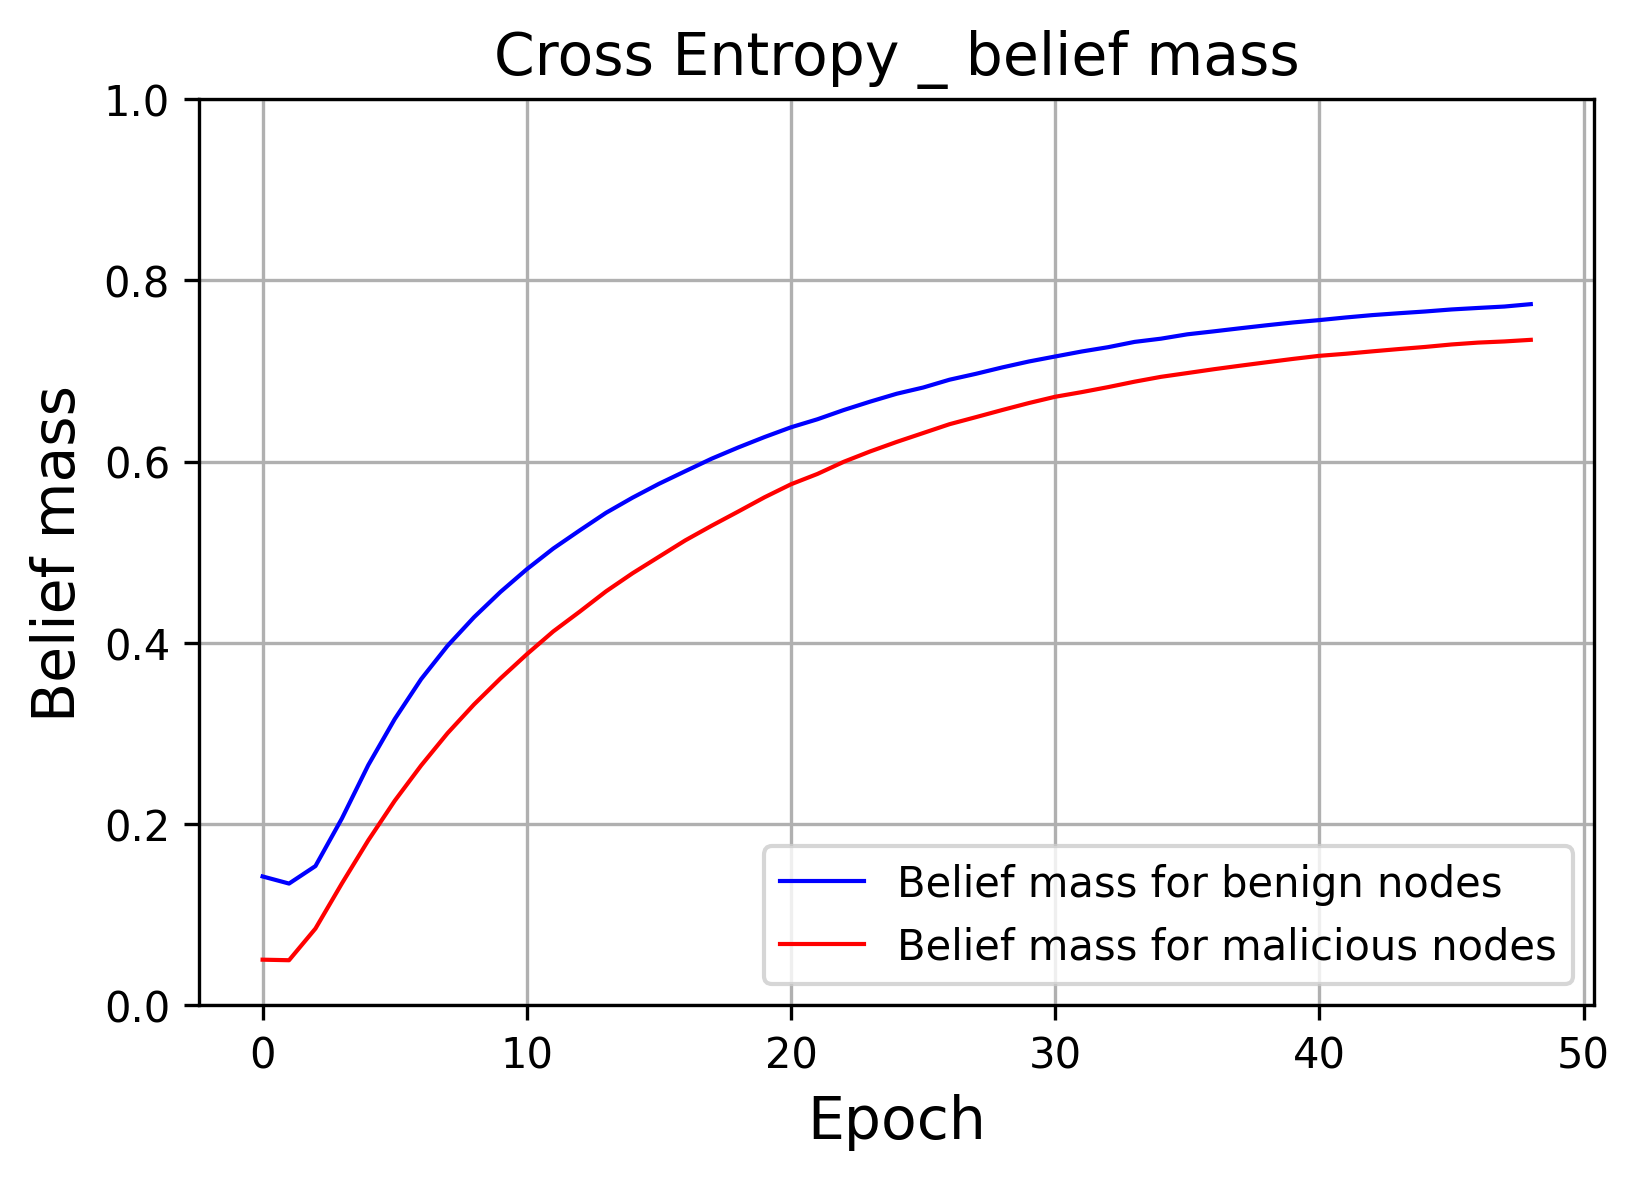

In [38]:
mean_positive_belief_mass=[]
mean_negative_belief_mass=[]
for i in range(0,len(belief_mass_vector)-1):
    mean_positive_belief_mass.append(np.mean(torch.Tensor.cpu(belief_mass_vector[i][:,0][belief_mass_vector[i][:,0] != 0]).detach().numpy()))
    mean_negative_belief_mass.append(np.mean(torch.Tensor.cpu(belief_mass_vector[i][:,1][belief_mass_vector[i][:,1] != 0]).detach().numpy()))
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 
x=np.arange(0, len(mean_positive_belief_mass[0:100]), 1, dtype=int)

#plt.plot(uncertainty_mass_vector_first_iteration, color='red',linewidth=0.1) 
#plt.plot(uncertainty_mass_vector_last_iteration, color='blue',linewidth=0.1)
plt.plot(x,mean_positive_belief_mass[0:100] ,color='blue',linewidth=1, label='Belief mass for benign nodes')
plt.plot(x,mean_negative_belief_mass[0:100] ,color='red',linewidth=1, label='Belief mass for malicious nodes')

#plt.title('Dirichlet _ belief mass', fontsize=14)
plt.title('Cross Entropy _ belief mass', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Belief mass', fontsize=14)
plt.legend(loc="lower right")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
#ax.set_ylim([ymin, ymax])
plt.grid(True)
plt.show()

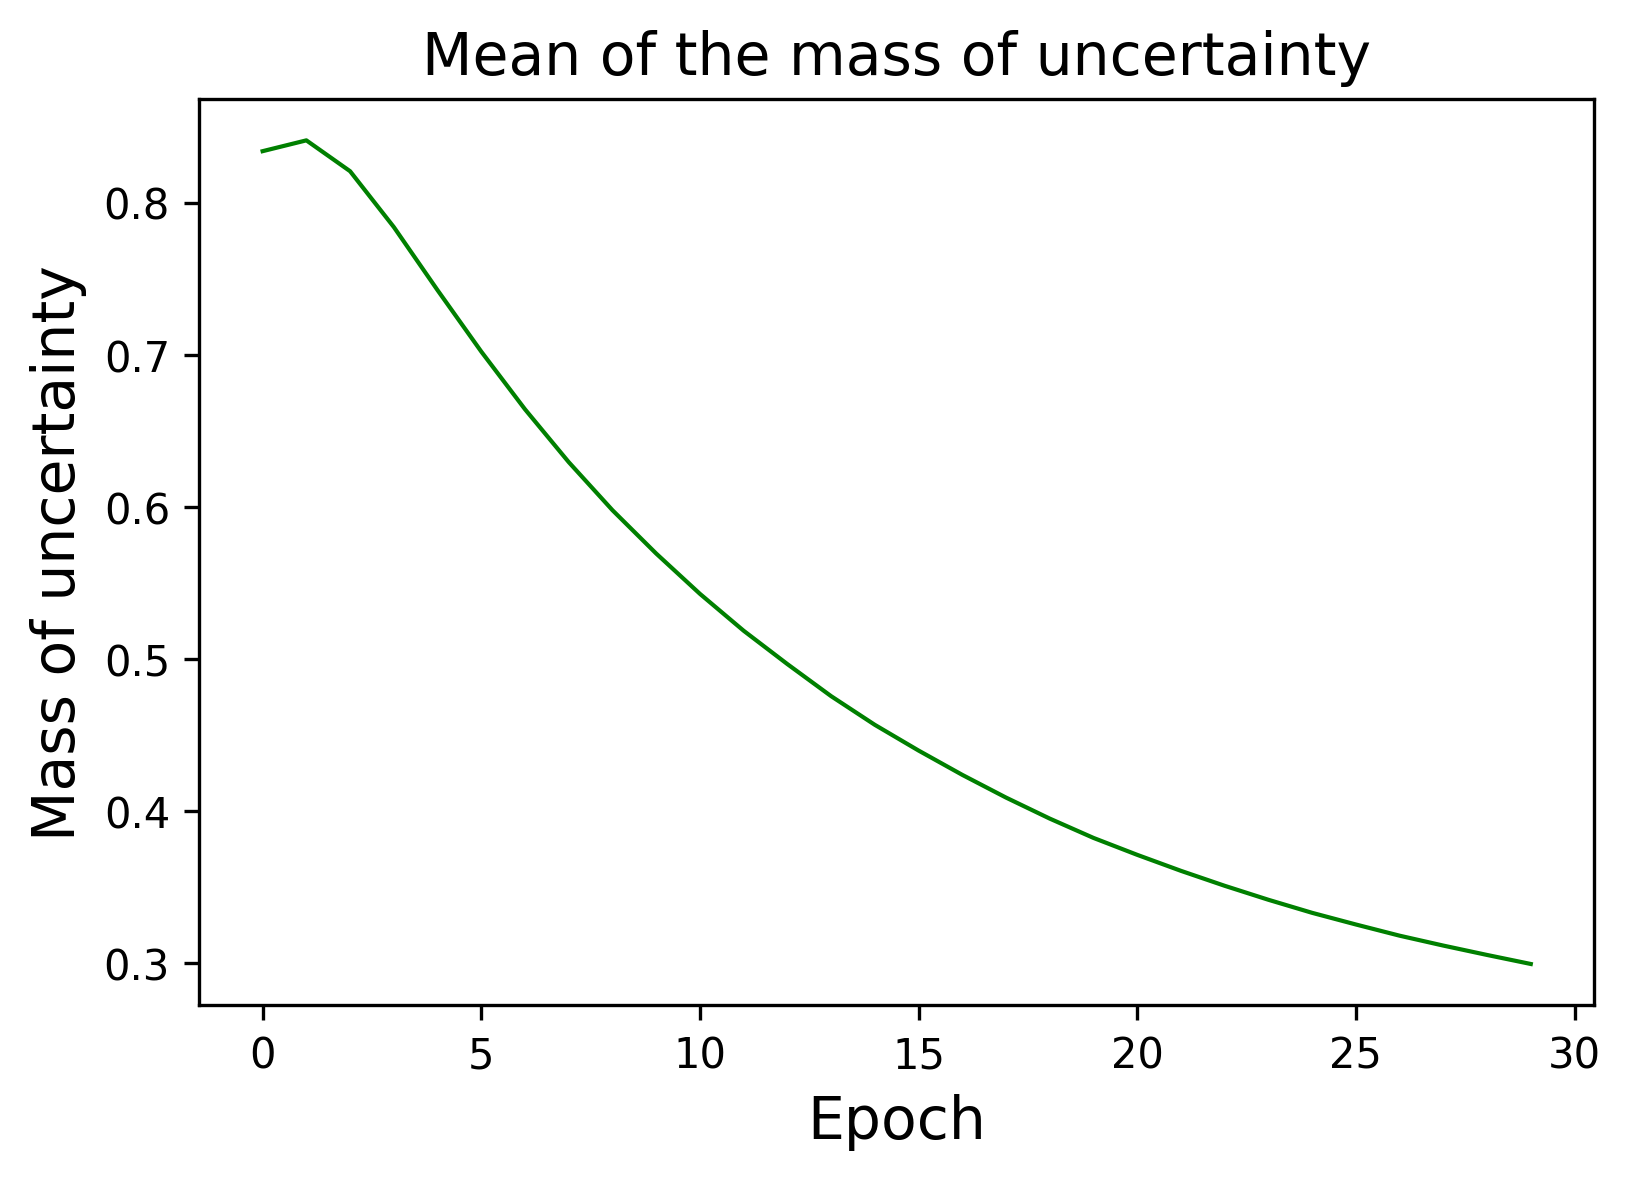

In [39]:
mean_uncertainty_mass=[]
for i in range(0,len(uncertainty_mass_vector)-1):
     mean_uncertainty_mass.append(np.mean(torch.Tensor.cpu(uncertainty_mass_vector[i]).detach().numpy()))
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 
x=np.arange(0, len(mean_uncertainty_mass[0:30]), 1, dtype=int)

#plt.plot(uncertainty_mass_vector_first_iteration, color='red',linewidth=0.1) 
#plt.plot(uncertainty_mass_vector_last_iteration, color='blue',linewidth=0.1)
plt.plot(x,mean_uncertainty_mass[0:30] ,color='green',linewidth=1)

plt.title('Mean of the mass of uncertainty', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mass of uncertainty', fontsize=14)
plt.grid(False)
plt.show()    

In [58]:
Performance = compute_performance(model, train_dataset)    

In [59]:
print(Performance.keys())

dict_keys(['Precision', 'Recall', 'Accuracy', 'F1_Score', 'tp', 'fp', 'tn', 'fn', 'tp_bf', 'fp_bf', 'tn_bf', 'fn_bf', 'tp_u', 'fp_u', 'tn_u', 'fn_u', 'uncertainty_mass_test_vector', 'belief_mass_test_vector', 'total_uncertainty_mass_vector', 'total_belief_mass_vector', 'n_uncertainty', 'pred', 'y_test', 'total_prediction'])


[TP] 57957	[FP] 0
[TN] 60387	[FN] 1610
Precision: 1.0000
Recall: 0.9730
Accuracy: 0.9866
F1 Score: 0.9863


<Figure size 1800x1200 with 0 Axes>

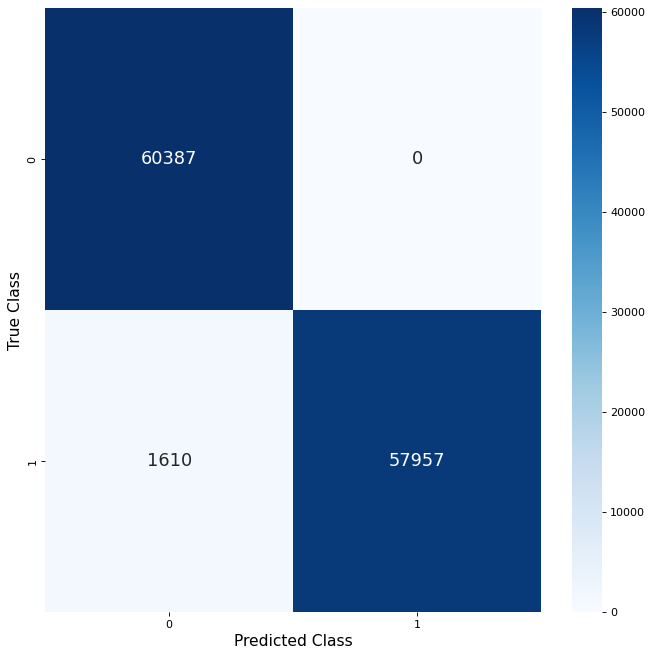

<Figure size 1800x1200 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
conf = [[Performance["tn"],Performance["fp"]],[Performance["fn"],Performance["tp"]]]
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g',cmap="Blues")
print('[TP] {}\t[FP] {}'.format(Performance["tp"], Performance["fp"]))
print('[TN] {}\t[FN] {}'.format(Performance["tn"], Performance["fn"]))  
print('Precision: %.4f' % Performance["Precision"])
print('Recall: %.4f' % Performance["Recall"])
print('Accuracy: %.4f' % Performance["Accuracy"])
print('F1 Score: %.4f' % Performance["F1_Score"])
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.figure()

# GNNExplainer

In [45]:
from collections import defaultdict

def get_malicious_devices():
    malicious_nodes= set()
    index=0
    for prediction in Performance["total_prediction"].tolist():
        if prediction==1:
            malicious_nodes.add(index) 
        index+=1    
    #set_of_devices= set()  
    set_of_devices = defaultdict(set)
    for node in malicious_nodes:
        set_of_devices[data.iloc[[node]]['IPV4_SRC_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0]].add(node)
        set_of_devices[data.iloc[[node]]['IPV4_DST_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0]].add(node)

        #set_of_devices.add(data.iloc[[node]]['IPV4_DST_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0])   
        #set_of_devices.add(data.iloc[[node]]['IPV4_SRC_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0])
    return set_of_devices

In [46]:
set_of_devices=get_malicious_devices()

In [48]:
print("Malicious devices found by model on unlabeled nodes: "+ str(set(set_of_devices.keys())))
print("\nGround truth of malicious devices: "+ str(np.unique([data1["IPV4_SRC_ADDR"], data1["IPV4_DST_ADDR"]])))


Malicious devices found by model on unlabeled nodes: {'149.171.126.12', '149.171.126.16', '175.45.176.2', '175.45.176.0', '149.171.126.17', '149.171.126.19', '149.171.126.18', '175.45.176.1', '149.171.126.14', '149.171.126.10', '192.168.241.243', '175.45.176.3', '149.171.126.11', '149.171.126.15', '149.171.126.13'}

Ground truth of malicious devices: ['149.171.126.10' '149.171.126.11' '149.171.126.12' '149.171.126.13'
 '149.171.126.14' '149.171.126.15' '149.171.126.16' '149.171.126.17'
 '149.171.126.18' '149.171.126.19' '175.45.176.0' '175.45.176.1'
 '175.45.176.2' '175.45.176.3']


In [52]:
device_target='149.171.126.12'

In [60]:
node_idx = 131076
x, edge_index = train_dataset.x, train_dataset.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 131076: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 45.84it/s]


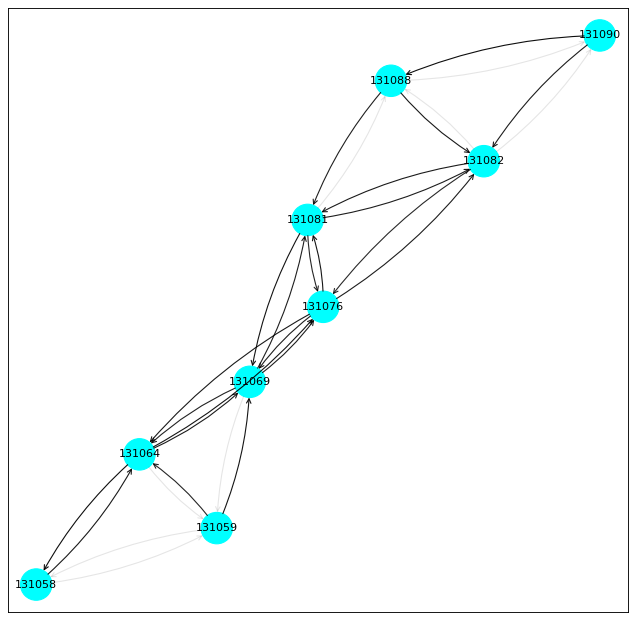

In [61]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
ax, G = explainer.visualize_subgraph(131076, edge_index, edge_mask, y=train_dataset.y)

plt.show()

In [62]:
data.iloc[[node_idx]]

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC,IPV4_DST,x,y
131076,175.45.176.1:59814,1.399062,149.171.126.11:514,-0.475996,-0.012717,0.101795,-0.046466,-0.141118,-0.161167,-0.22304,-1.459059,-0.088055,1.006463,0.017971,"[-0.1411178161212793, -0.1611667065473456, -0....",1


In [63]:
print("Communications analyzed: \n"+str(data.iloc[[node_idx]]))
print("Pediction: "+str(Performance["total_prediction"].tolist()[node_idx]))


Communications analyzed: 
             IPV4_SRC_ADDR  L4_SRC_PORT       IPV4_DST_ADDR  L4_DST_PORT  \
131076  175.45.176.1:59814     1.399062  149.171.126.11:514    -0.475996   

        PROTOCOL  L7_PROTO  IN_BYTES  OUT_BYTES   IN_PKTS  OUT_PKTS  \
131076 -0.012717  0.101795 -0.046466  -0.141118 -0.161167  -0.22304   

        TCP_FLAGS  FLOW_DURATION_MILLISECONDS  IPV4_SRC  IPV4_DST  \
131076  -1.459059                   -0.088055  1.006463  0.017971   

                                                        x  y  
131076  [-0.1411178161212793, -0.1611667065473456, -0....  1  
Pediction: 1


In [66]:
print("The following communications are decisive for classifying the communication analyzed:")
for node in G.nodes:
    print(data.iloc[[node]])
    print("\nuncertainy"+str(Performance["total_uncertainty_mass_vector"][node]))
    print("belief_mass_vector"+str(Performance["total_belief_mass_vector"][node])+str("\n"))
    
print("\n\nThe devices strongly connected to the communication analyzed are the following:")
set_of_devices= set()
for node in G.nodes:
    set_of_devices.add(data.iloc[[node]]['IPV4_DST_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0])

for device in set_of_devices:
    print(str(device))

The following communications are decisive for classifying the communication analyzed:
             IPV4_SRC_ADDR  L4_SRC_PORT      IPV4_DST_ADDR  L4_DST_PORT  \
131058  175.45.176.1:37068     0.307013  149.171.126.15:80    -0.502002   

        PROTOCOL  L7_PROTO  IN_BYTES  OUT_BYTES   IN_PKTS  OUT_PKTS  \
131058 -0.312036 -0.286307 -0.046776  -0.139958 -0.120664 -0.187255   

        TCP_FLAGS  FLOW_DURATION_MILLISECONDS  IPV4_SRC  IPV4_DST  \
131058   0.170132                   -0.085743  1.006463  0.017971   

                                                        x  y  
131058  [-0.1399577790115274, -0.12066417489277745, -0...  1  

uncertainytensor([0.2509], device='cuda:0', grad_fn=<SelectBackward0>)
belief_mass_vectortensor([0.0000, 0.7491], device='cuda:0', grad_fn=<SelectBackward0>)

         IPV4_SRC_ADDR  L4_SRC_PORT     IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
131059  175.45.176.1:0    -1.472645  149.171.126.10:0    -0.506795    3.0621   

        L7_PROTO  IN_BYTES  OUT_BY